# Statistical values distribution - Cortical Surface Area

In [1]:
from IPython.display import display, Image
import plotly.io as pio
from pathlib import Path

force = True
anonymizer = True

root_dir = Path.cwd().parent.parent.parent

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Root directory: {anondir(root_dir)}")
figures_dir = root_dir / "results" / "longitudinal" / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)
print(f"Figures directory: {anondir(figures_dir)}")
data_dir = root_dir / "data" 
print(f"Data directory: {anondir(data_dir)}")
results_dir = root_dir / "results" / "longitudinal"
print(f"Results directory: {anondir(results_dir)}")


# This is a static rendering of the notebook.
def show_figure(fig, width=1440, height=900):
    fig.update_layout(width=width, height=height)
    fig.show()


def write_image(fig, filename, width=1440, height=900):
    display(Image(fig.to_image(format="png", width=width, height=height, scale=2)))
    fig.write_image(
        figures_dir / filename,
        width=width,
        height=height,
        scale=2,  # Higher DPI
        engine="kaleido",
    )

Root directory: <living-park>
Figures directory: <living-park>/results/longitudinal/figures
Data directory: <living-park>/data
Results directory: <living-park>/results/longitudinal


In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import plotly

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Define cortical regions - these should represent cortical areas
cortical_regions = [
    "bankssts",
    "caudalanteriorcingulate",
    "caudalmiddlefrontal",
    "cuneus",
    "entorhinal",
    "fusiform",
    "inferiorparietal",
    "inferiortemporal",
    "isthmuscingulate",
    "lateraloccipital",
    "lateralorbitofrontal",
    "lingual",
    "medialorbitofrontal",
    "middletemporal",
    "parahippocampal",
    "paracentral",
    "parsopercularis",
    "parsorbitalis",
    "parstriangularis",
    "pericalcarine",
    "postcentral",
    "posteriorcingulate",
    "precentral",
    "precuneus",
    "rostralanteriorcingulate",
    "rostralmiddlefrontal",
    "superiorfrontal",
    "superiorparietal",
    "superiortemporal",
    "supramarginal",
    "frontalpole",
    "temporalpole",
    "transversetemporal",
    "insula",
]


# Define hemisphere-specific symbols
def get_hemisphere_symbol(hemi):
    """Return symbol based on hemisphere"""
    if hemi == "Left":
        return "triangle-left"
    elif hemi == "Right":
        return "triangle-right"
    else:
        return "diamond"


def get_hemisphere_color(hemi):
    """Return color based on hemisphere"""
    return plotly.colors.qualitative.Set1[0]  # Red for other


red = plotly.colors.qualitative.Set1[0]
ieee_marker = dict(color=red, symbol="diamond", size=10)
violin_width = 0.85
violin_jitter = 0.85


## Utils functions

In [ ]:
def get_data(test, study, ieee=False):
    if ieee:
      filename = (
        results_dir /
        (test + "_ieee") /
        f"{test}_{study}_area.csv"
      )
      data = pd.read_csv(filename)
      data["fs_version"] = "IEEE"
      return data
    else:
      filename = (
        data_dir /
        test /
        f"{test}_{study}_area.parquet"
      )
      data = pd.read_parquet(filename)
      data["significant"] = data["p-val"] < 0.05
      stat = "r" if test == "partial_correlation" else "F"
      data_avg = data.groupby(["hemisphere", "region"]).agg({stat: "mean", "significant": "mean"}).reset_index()    
      return data, data_avg

        
def get_preprocessed_data(test, study):
    data, data_avg = get_data(test, study)
    ieee_data = get_data(test, study, ieee=True)
    
    # Filter out the regions that are not in the data
    data = data[data["region"].isin(cortical_regions)]
    data_avg = data_avg[data_avg["region"].isin(cortical_regions)]
    ieee_data = ieee_data[ieee_data["region"].isin(cortical_regions)]
    
    # Create a position mapping dictionary
    region_to_position = {region: i for i, region in enumerate(cortical_regions)}

    # Add position columns to each dataframe
    data["position"] = data["region"].map(
        region_to_position
    )
    data_avg["position"] = data_avg["region"].map(region_to_position)
    ieee_data["position"] = ieee_data["region"].map(region_to_position)

    # Add hemisphere info
    for df in [data, data_avg, ieee_data]:
        df["hemisphere"] = df["hemisphere"].apply(
            lambda x: "Left" if x.startswith("lh") else "Right"
        )
        df["symbol"] = df["region"].apply(get_hemisphere_symbol)
        df["hemisphere_color"] = df["region"].apply(get_hemisphere_color)

    # Sort by position to ensure correct order
    data.sort_values(by="position", inplace=True)
    data_avg.sort_values(by="position", inplace=True)
    ieee_data.sort_values(by="position", inplace=True)
    
    return {
        "data": data,
        "data_avg": data_avg,
        "ieee_data": ieee_data,
    }    

In [ ]:
def add_pcorr_baseline_cortical_trace(fig, data, hemi=None):
    """Add baseline partial correlation traces for cortical area"""
    row, col = 1, 1

    baseline_cortical_area = data["data"]
    ieee_data = data["ieee_data"]

    baseline_cortical_area = baseline_cortical_area[
        baseline_cortical_area["hemisphere"] == hemi
    ]

    # Add violin plot
    violin = go.Violin(
        x=baseline_cortical_area["region"],
        y=baseline_cortical_area["r"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        meanline_visible=True,
        fillcolor="gray",
        opacity=0.6,
        width=violin_width,
        jitter=violin_jitter,
        showlegend=False,
        name="r coefficient",
        # spanmode="hard",
        points="all",
        pointpos=0,
        marker=dict(color="orange", opacity=1),
        customdata=baseline_cortical_area["region"],
        hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
    )

    # Add IEEE data with hemisphere-specific symbols
    hemispheres = [hemi] if hemi else ["Left", "Right"]
    for hemisphere in hemispheres:
        ieee_hemisphere = ieee_data[ieee_data["hemisphere"] == hemisphere]
        if not ieee_hemisphere.empty:
            symbol = get_hemisphere_symbol(hemisphere)
            color = get_hemisphere_color(hemisphere)
            ieee_scatter = go.Scatter(
                x=ieee_hemisphere["region"],
                y=ieee_hemisphere["r"],
                mode="markers",
                yaxis="y2",
                marker=dict(color=color, symbol=symbol, size=10),
                showlegend=True,
                name=f"IEEE {hemisphere}",
                customdata=ieee_hemisphere["region"],
                hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
            )
            fig.add_trace(ieee_scatter, row=row, col=col)

    fig.add_trace(violin, row=row, col=col)

In [ ]:
def add_pcorr_longitudinal_cortical_trace(fig, data, hemi=None):
    """Add longitudinal partial correlation traces for cortical area"""
    row, col = 1, 2

    longitudinal_cortical_area = data["data"]
    ieee_data = data["ieee_data"]

    longitudinal_cortical_area = longitudinal_cortical_area[
        longitudinal_cortical_area["hemisphere"] == hemi
    ]

    violin = go.Violin(
        x=longitudinal_cortical_area["region"],
        y=longitudinal_cortical_area["r"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        meanline_visible=True,
        fillcolor="gray",
        opacity=0.6,
        width=violin_width,
        jitter=violin_jitter,
        showlegend=False,
        # spanmode="hard",
        name="r coefficient",
        points="all",
        marker=dict(color="orange", opacity=1),
        pointpos=0,
        customdata=longitudinal_cortical_area["region"],
        hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
    )

    # Add IEEE data with hemisphere-specific symbols
    hemispheres = [hemi] if hemi else ["Left", "Right"]
    for hemisphere in hemispheres:
        ieee_hemisphere = ieee_data[ieee_data["hemisphere"] == hemisphere]
        if not ieee_hemisphere.empty:
            symbol = get_hemisphere_symbol(hemisphere)
            color = get_hemisphere_color(hemisphere)
            ieee_scatter = go.Scatter(
                x=ieee_hemisphere["region"],
                y=ieee_hemisphere["r"],
                mode="markers",
                yaxis="y2",
                marker=dict(color=color, symbol=symbol, size=10),
                showlegend=False,
                name=f"IEEE {hemisphere}",
                customdata=ieee_hemisphere["region"],
                hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
            )
            fig.add_trace(ieee_scatter, row=row, col=col)

    fig.add_trace(violin, row=row, col=col)

In [ ]:
def add_ancova_baseline_cortical_trace(fig, data, hemi=None):
    """Add baseline ANCOVA traces for cortical area"""
    row, col = 2, 1

    baseline_cortical_area = data["data"]
    ieee_data = data["ieee_data"]

    baseline_cortical_area = baseline_cortical_area[
        baseline_cortical_area["hemisphere"] == hemi
    ]

    violin = go.Violin(
        x=baseline_cortical_area["region"],
        y=baseline_cortical_area["F"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        meanline_visible=True,
        fillcolor="gray",
        opacity=0.6,
        width=violin_width,
        jitter=violin_jitter,
        showlegend=False,
        marker=dict(color="orange", opacity=1),
        pointpos=0,
        name="F-value",
        spanmode="hard",
        points="all",
        customdata=baseline_cortical_area["region"],
        hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
    )

    # Add IEEE data with hemisphere-specific symbols
    hemispheres = [hemi] if hemi else ["Left", "Right"]
    for hemisphere in hemispheres:
        ieee_hemisphere = ieee_data[ieee_data["hemisphere"] == hemisphere]
        if not ieee_hemisphere.empty:
            symbol = get_hemisphere_symbol(hemisphere)
            color = get_hemisphere_color(hemisphere)
            ieee_scatter = go.Scatter(
                x=ieee_hemisphere["region"],
                y=ieee_hemisphere["F"],
                mode="markers",
                yaxis="y2",
                marker=dict(color=color, symbol=symbol, size=10),
                showlegend=False,
                name=f"IEEE {hemisphere}",
                customdata=ieee_hemisphere["region"],
                hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
            )
            fig.add_trace(ieee_scatter, row=row, col=col)

    fig.add_trace(violin, row=row, col=col)

In [ ]:
def add_ancova_longitudinal_cortical_trace(fig, data, hemi=None):
    """Add longitudinal ANCOVA traces for cortical area"""
    row, col = 2, 2

    longitudinal_cortical_area = data["data"]
    ieee_data = data["ieee_data"]

    longitudinal_cortical_area = longitudinal_cortical_area[
        longitudinal_cortical_area["hemisphere"] == hemi
    ]

    violin = go.Violin(
        x=longitudinal_cortical_area["region"],
        y=longitudinal_cortical_area["F"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        fillcolor="gray",
        meanline_visible=False,
        pointpos=0,
        marker=dict(
            color="orange",
            opacity=1,
        ),
        width=violin_width,
        jitter=violin_jitter,
        opacity=0.6,
        showlegend=False,
        name="F-value",
        points="all",
        spanmode="hard",
        customdata=longitudinal_cortical_area["region"],
        hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
    )

    # Add IEEE data with hemisphere-specific symbols
    hemispheres = [hemi] if hemi else ["Left", "Right"]
    for hemisphere in hemispheres:
        ieee_hemisphere = ieee_data[ieee_data["hemisphere"] == hemisphere]
        if not ieee_hemisphere.empty:
            symbol = get_hemisphere_symbol(hemisphere)
            color = get_hemisphere_color(hemisphere)
            ieee_scatter = go.Scatter(
                x=ieee_hemisphere["region"],
                y=ieee_hemisphere["F"],
                mode="markers",
                yaxis="y2",
                marker=dict(color=color, symbol=symbol, size=10),
                showlegend=False,
                name=f"IEEE {hemisphere}",
                customdata=ieee_hemisphere["region"],
                hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
            )
            fig.add_trace(ieee_scatter, row=row, col=col)

    fig.add_trace(violin, row=row, col=col)

## Consistency of Statistically Significant Regions

This analysis quantifies the consistency of statistically significant findings across different brain regions. For each region, we compute the proportion of statistical tests that yield significant results relative to the total number of tests performed. 

Number of cortical regions: 34


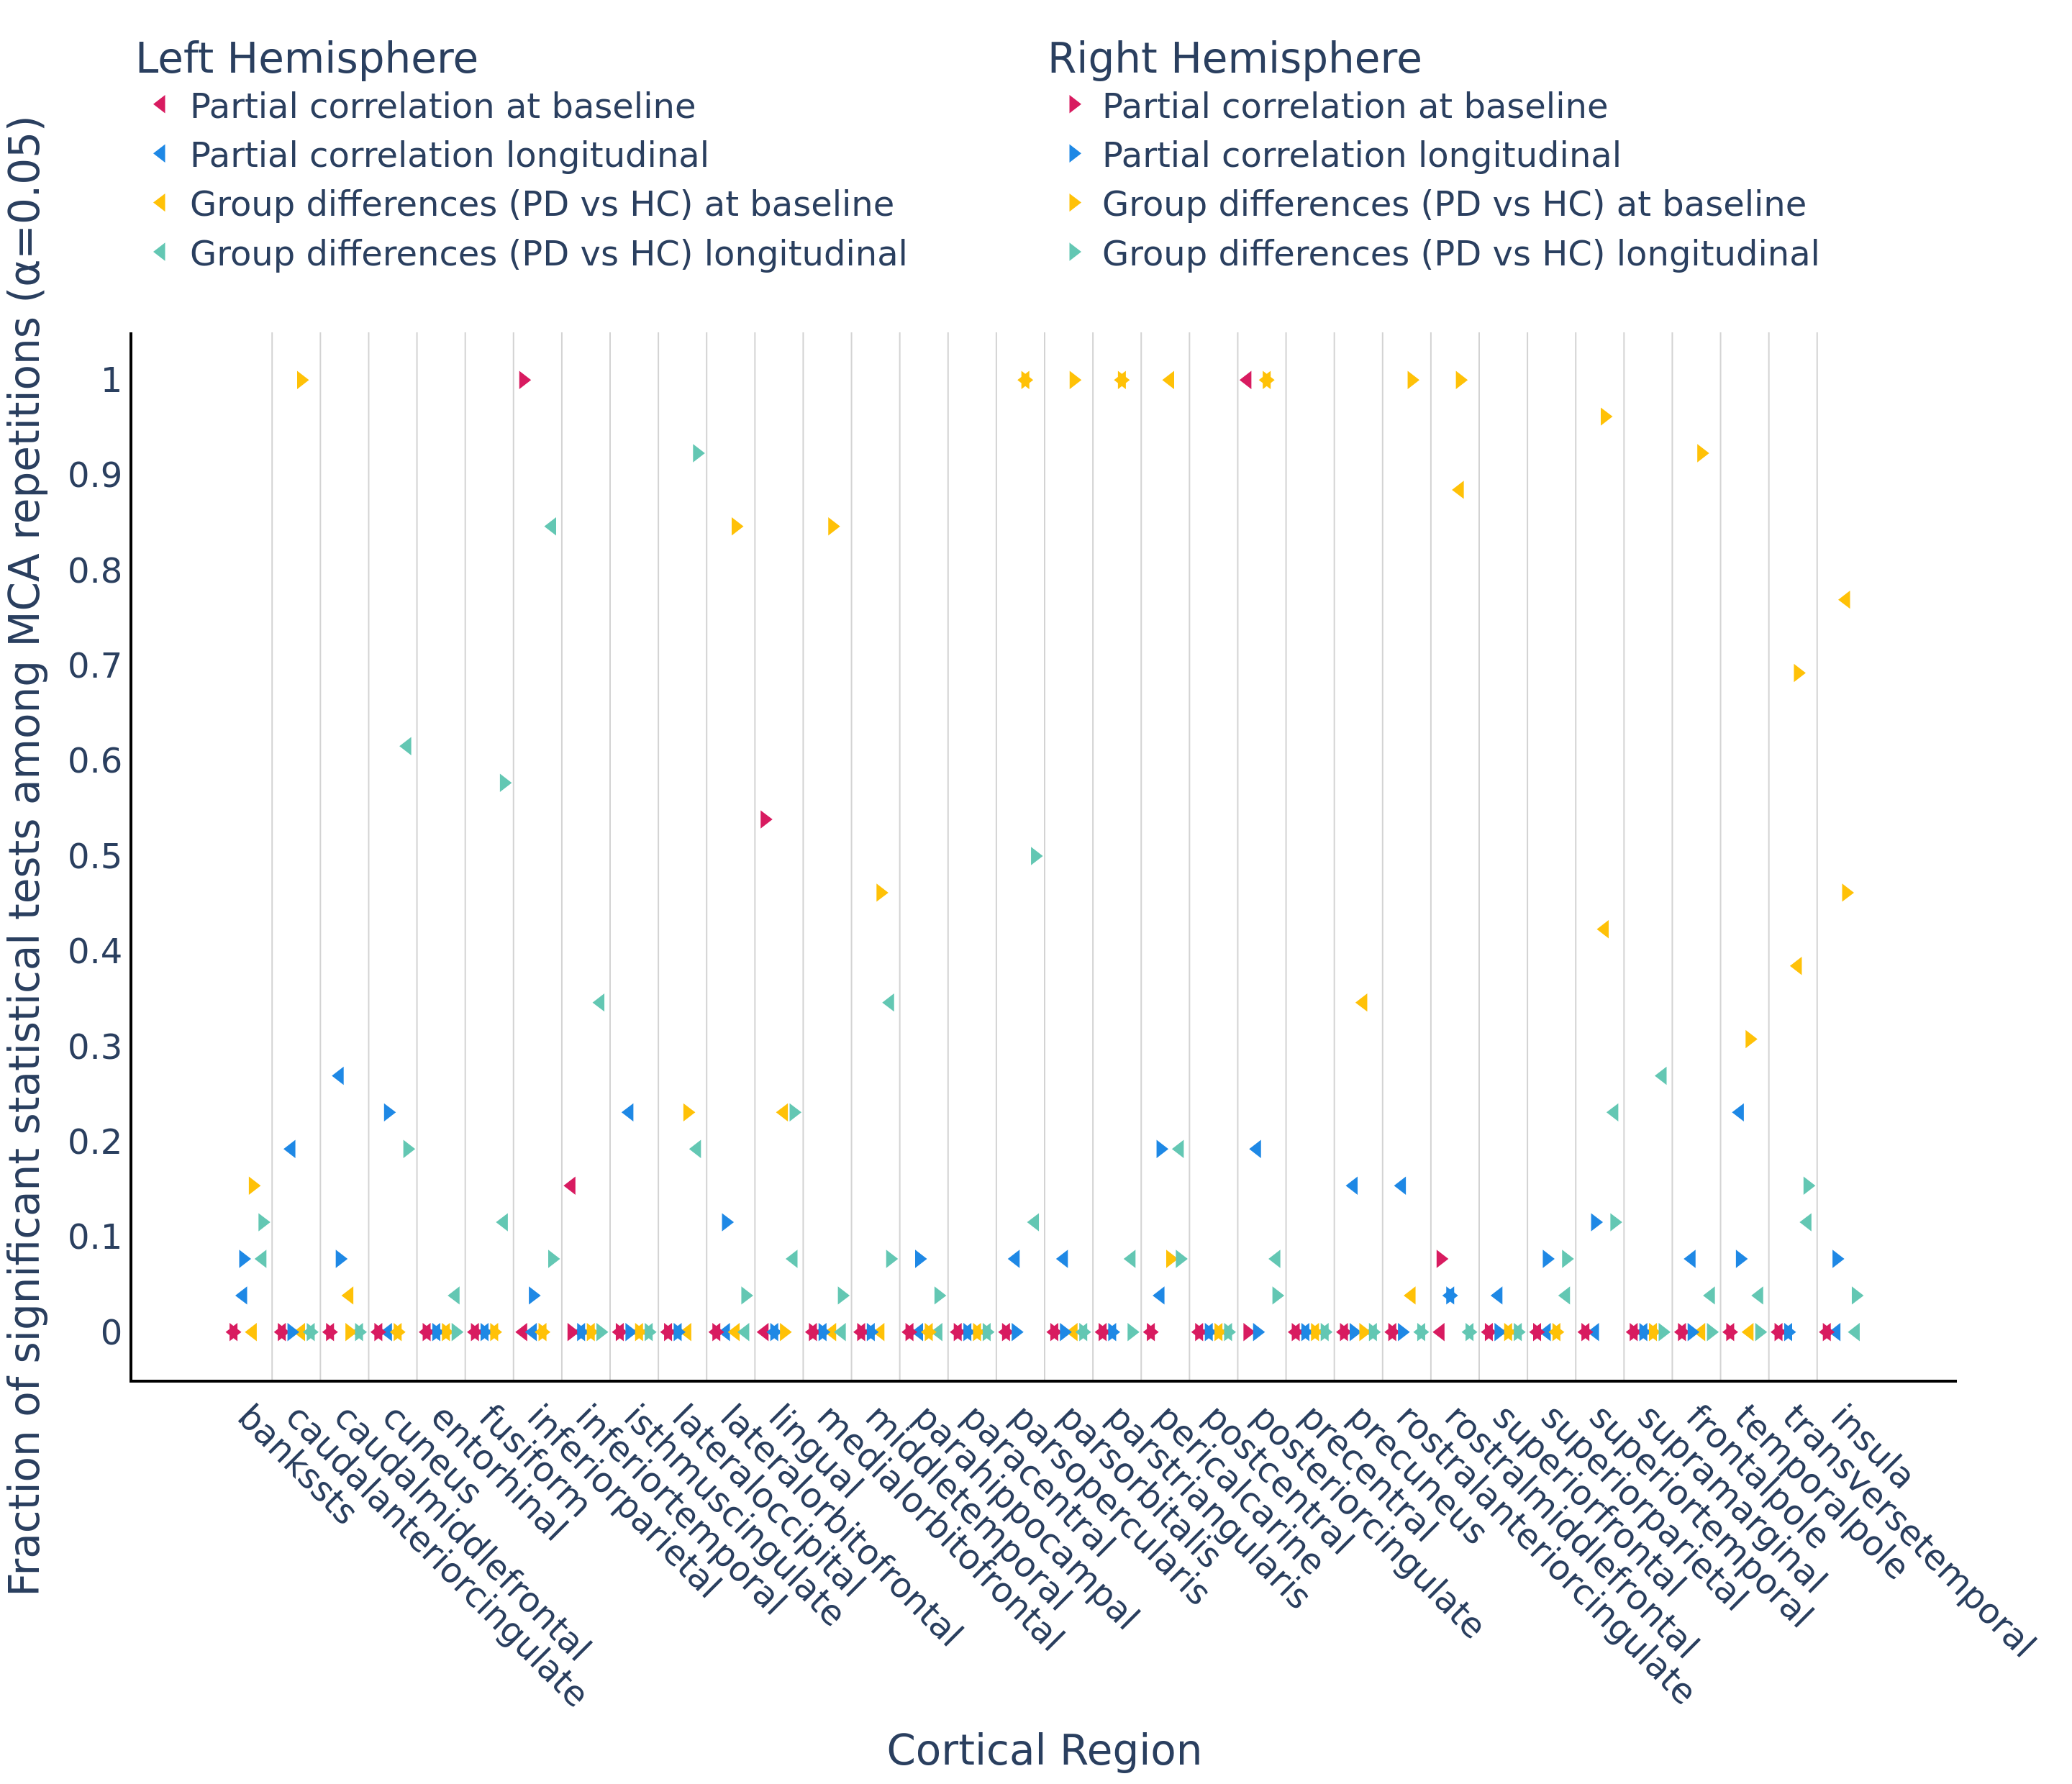

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np


# Significance correlation plot for cortical thickness
pcorr_baseline_cortical_avg = get_preprocessed_data(
    "partial_correlation", "baseline"
)["data_avg"]
pcorr_longitudinal_cortical_avg = get_preprocessed_data(
    "partial_correlation", "longitudinal"
)["data_avg"]
ancova_baseline_cortical_avg = get_preprocessed_data(
    "ancova", "baseline"
)["data_avg"]
ancova_longitudinal_cortical_avg = get_preprocessed_data(
    "ancova", "longitudinal"
)["data_avg"]

print(f"Number of cortical regions: {len(cortical_regions)}")

fig = go.Figure()

colormap = px.colors.qualitative.Plotly
# colorblind palette: blue, red, green, yellow
colormap = ["#D81B60", "#1E88E5", "#FFC107", "#63C7B3","#63C7B7"]
marker_size = 11
marker_line = dict(width=0, color="White")
font_family = "Helvetica, Arial, sans-serif"


def get_jittered_positions(length, jitter_amount):
    """Generate jittered x-axis positions"""
    return [x + jitter_amount for x in range(length)]


def get_legend(hemisphere):
    return {"Left": "legend", "Right": "legend2"}[hemisphere]


# Create hemisphere-specific traces with manual legend positioning
left_traces = []
right_traces = []

for hemisphere, symbol, short_name in [
    ("Left", "triangle-left", "Left"),
    ("Right", "triangle-right", "Right"),
]:
    traces_for_hemisphere = []

    # Partial correlation baseline
    data_subset = pcorr_baseline_cortical_avg[
        pcorr_baseline_cortical_avg["hemisphere"] == hemisphere
    ]
    if not data_subset.empty:
        pcorr_base = go.Scatter(
            x=get_jittered_positions(len(data_subset), -0.3),
            y=data_subset["significant"],
            mode="markers",
            marker=dict(
                color=colormap[0], size=marker_size, symbol=symbol, line=marker_line
            ),
            name=f"Partial correlation at baseline",
            text=data_subset["region"],
            legend=get_legend(hemisphere),
            legendgroup=hemisphere,
        )
        traces_for_hemisphere.append(pcorr_base)
    else:
        raise ValueError(f"No data for Partial correlation baseline - {hemisphere}")

    # Partial correlation longitudinal
    data_subset = pcorr_longitudinal_cortical_avg[
        pcorr_longitudinal_cortical_avg["hemisphere"] == hemisphere
    ]

    if not data_subset.empty:
        pcorr_long = go.Scatter(
            x=get_jittered_positions(len(data_subset), -0.1),
            y=data_subset["significant"],
            mode="markers",
            marker=dict(
                color=colormap[1], size=marker_size, symbol=symbol, line=marker_line
            ),
            name=f"Partial correlation longitudinal",
            legend=get_legend(hemisphere),
            legendgroup=hemisphere,
        )
        traces_for_hemisphere.append(pcorr_long)
    else:
        raise ValueError(
            f"No data for Partial correlation longitudinal - {hemisphere} hemisphere"
        )

    # ANCOVA baseline
    data_subset = ancova_baseline_cortical_avg[
        ancova_baseline_cortical_avg["hemisphere"] == hemisphere
    ]
    if not data_subset.empty:
        ancova_base = go.Scatter(
            x=get_jittered_positions(len(data_subset), 0.1),
            y=data_subset["significant"],
            mode="markers",
            marker=dict(
                color=colormap[2], size=marker_size, symbol=symbol, line=marker_line
            ),
            name=f"Group differences (PD vs HC) at baseline",
            legend=get_legend(hemisphere),
            legendgroup=hemisphere,
        )
        traces_for_hemisphere.append(ancova_base)
    else:
        raise ValueError(f"No data for ANCOVA baseline - {hemisphere} hemisphere")

    # ANCOVA longitudinal
    data_subset = ancova_longitudinal_cortical_avg[
        ancova_longitudinal_cortical_avg["hemisphere"] == hemisphere
    ]
    if not data_subset.empty:
        ancova_long = go.Scatter(
            x=get_jittered_positions(len(data_subset), 0.3),
            y=data_subset["significant"],
            mode="markers",
            marker=dict(
                color=colormap[3], size=marker_size, symbol=symbol, line=marker_line
            ),
            name=f"Group differences (PD vs HC) longitudinal",
            legend=get_legend(hemisphere),
            legendgroup=hemisphere,
        )
        traces_for_hemisphere.append(ancova_long)
    else:
        raise ValueError(f"No data for ANCOVA longitudinal - {hemisphere} hemisphere")

    if hemisphere == "Left":
        left_traces = traces_for_hemisphere
    else:
        right_traces = traces_for_hemisphere

# Add Left hemisphere traces first (will appear in top row)
for trace in left_traces:
    fig.add_trace(trace)

# Add Right hemisphere traces (will appear in bottom row)
for trace in right_traces:
    fig.add_trace(trace)

fig.update_xaxes(
    title="Cortical Region",
    tickmode="array",
    tickvals=list(range(len(cortical_regions))),
    ticktext=cortical_regions,
    tickangle=45,
)
fig.update_yaxes(
    title="Fraction of significant statistical tests among MCA repetitions (α=0.05)",
    range=[-0.05, 1.05],
    dtick=0.1,
)

background_color = "White"
# Update layout with two-row legend configuration
fig.update_layout(
    title_font_family=font_family,
    legend=dict(
        title="Left Hemisphere",
        font_size=24,
        orientation="v",
        yanchor="top",
        y=1.3,
        xanchor="left",
        xref="paper",
        yref="paper",
        x=0,
        traceorder="normal",  # Keep original order
        bgcolor="rgba(255, 255, 255, 0)",
        groupclick="toggleitem",
        # indentation=-15,
        # tracegroupgap=20,  # Space between Left and Right groups
    ),
    legend2=dict(
        title="Right Hemisphere",
        font_size=24,
        orientation="v",
        yanchor="top",
        y=1.3,
        xanchor="left",
        xref="paper",
        yref="paper",
        x=0.5,
        traceorder="normal",  # Keep original order
        bgcolor="rgba(255, 255, 255, 0)",
        groupclick="toggleitem",
        # indentation=-15,
        # tracegroupgap=20,  # Space between Left and Right groups
    ),
    # margin=dict(l=0, r=20, t=100, b=50),
    plot_bgcolor=background_color,
    paper_bgcolor=background_color,
)

fig.update_xaxes(title_font=dict(family=font_family))
fig.update_yaxes(title_font=dict(family=font_family))

# Turn off default grid lines
fig.update_xaxes(
    gridcolor="LightGray",
    gridwidth=1,
    zeroline=False,
    showgrid=False,  # Turn off default grid
    showline=True,
    linewidth=2,
    linecolor="black",
)
fig.update_yaxes(
    gridcolor="LightGray",
    gridwidth=1,
    zeroline=False,
    showgrid=False,
    showline=True,
    linewidth=2,
    linecolor="black",
)

# Add custom vertical grid lines positioned between cortical regions
for i in range(len(cortical_regions) - 1):
    fig.add_vline(x=i + 0.5, line=dict(color="LightGray", width=1), layer="below")

# Add horizontal reference line
# fig.add_hline(y=0.5, line_color="black", line_width=1, line_dash="dash")
# Increase font size
fig.update_layout(font=dict(size=24))
# fig.update_layout(legend=dict(font=dict(size=22)))

for annotation in fig["layout"]["annotations"]:
    if annotation["text"] == "Cortical Region":
        annotation["font"]["size"] = 26

# Save the figure (uncomment if you have kaleido installed)
write_image(fig, "cortical_area_significance_correlation.pdf", width=1440, height=1240)
show_figure(fig, width=1440, height=1240)

## Distribution of Statistical Values

Distribution of statistical values, specifically the correlation coefficients (r) from partial correlation analyses and the F-values from ANCOVA tests.

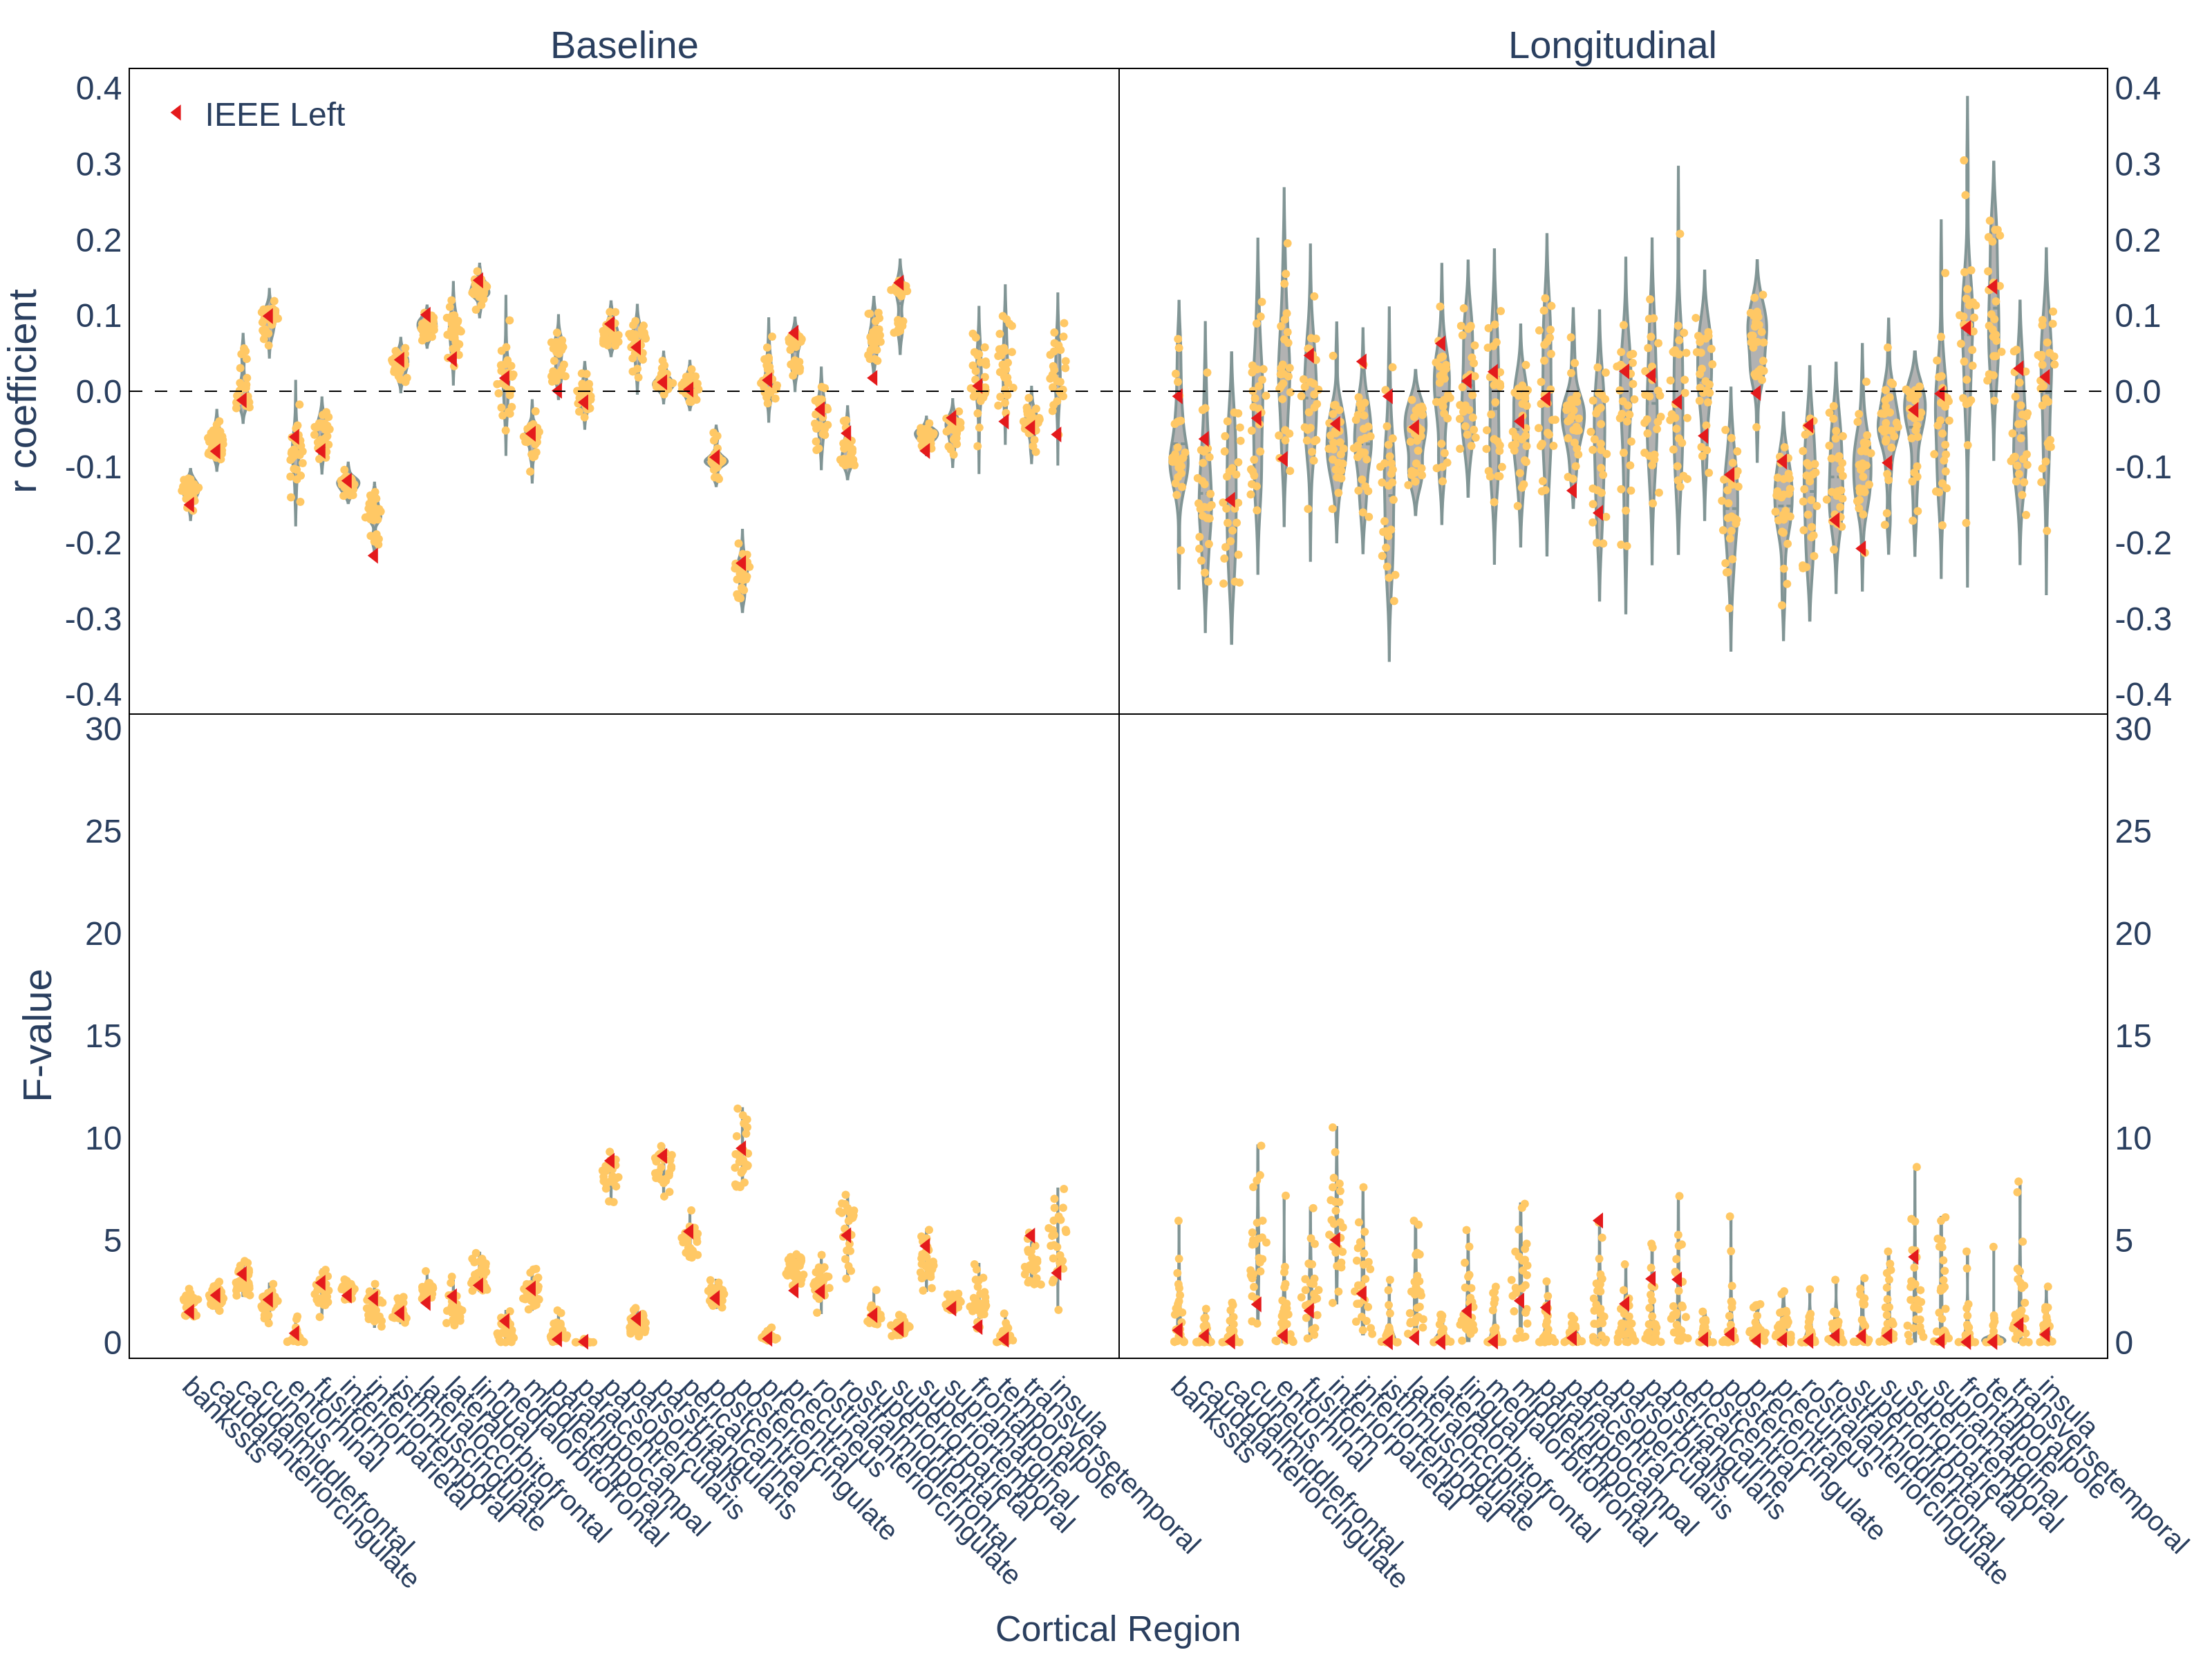

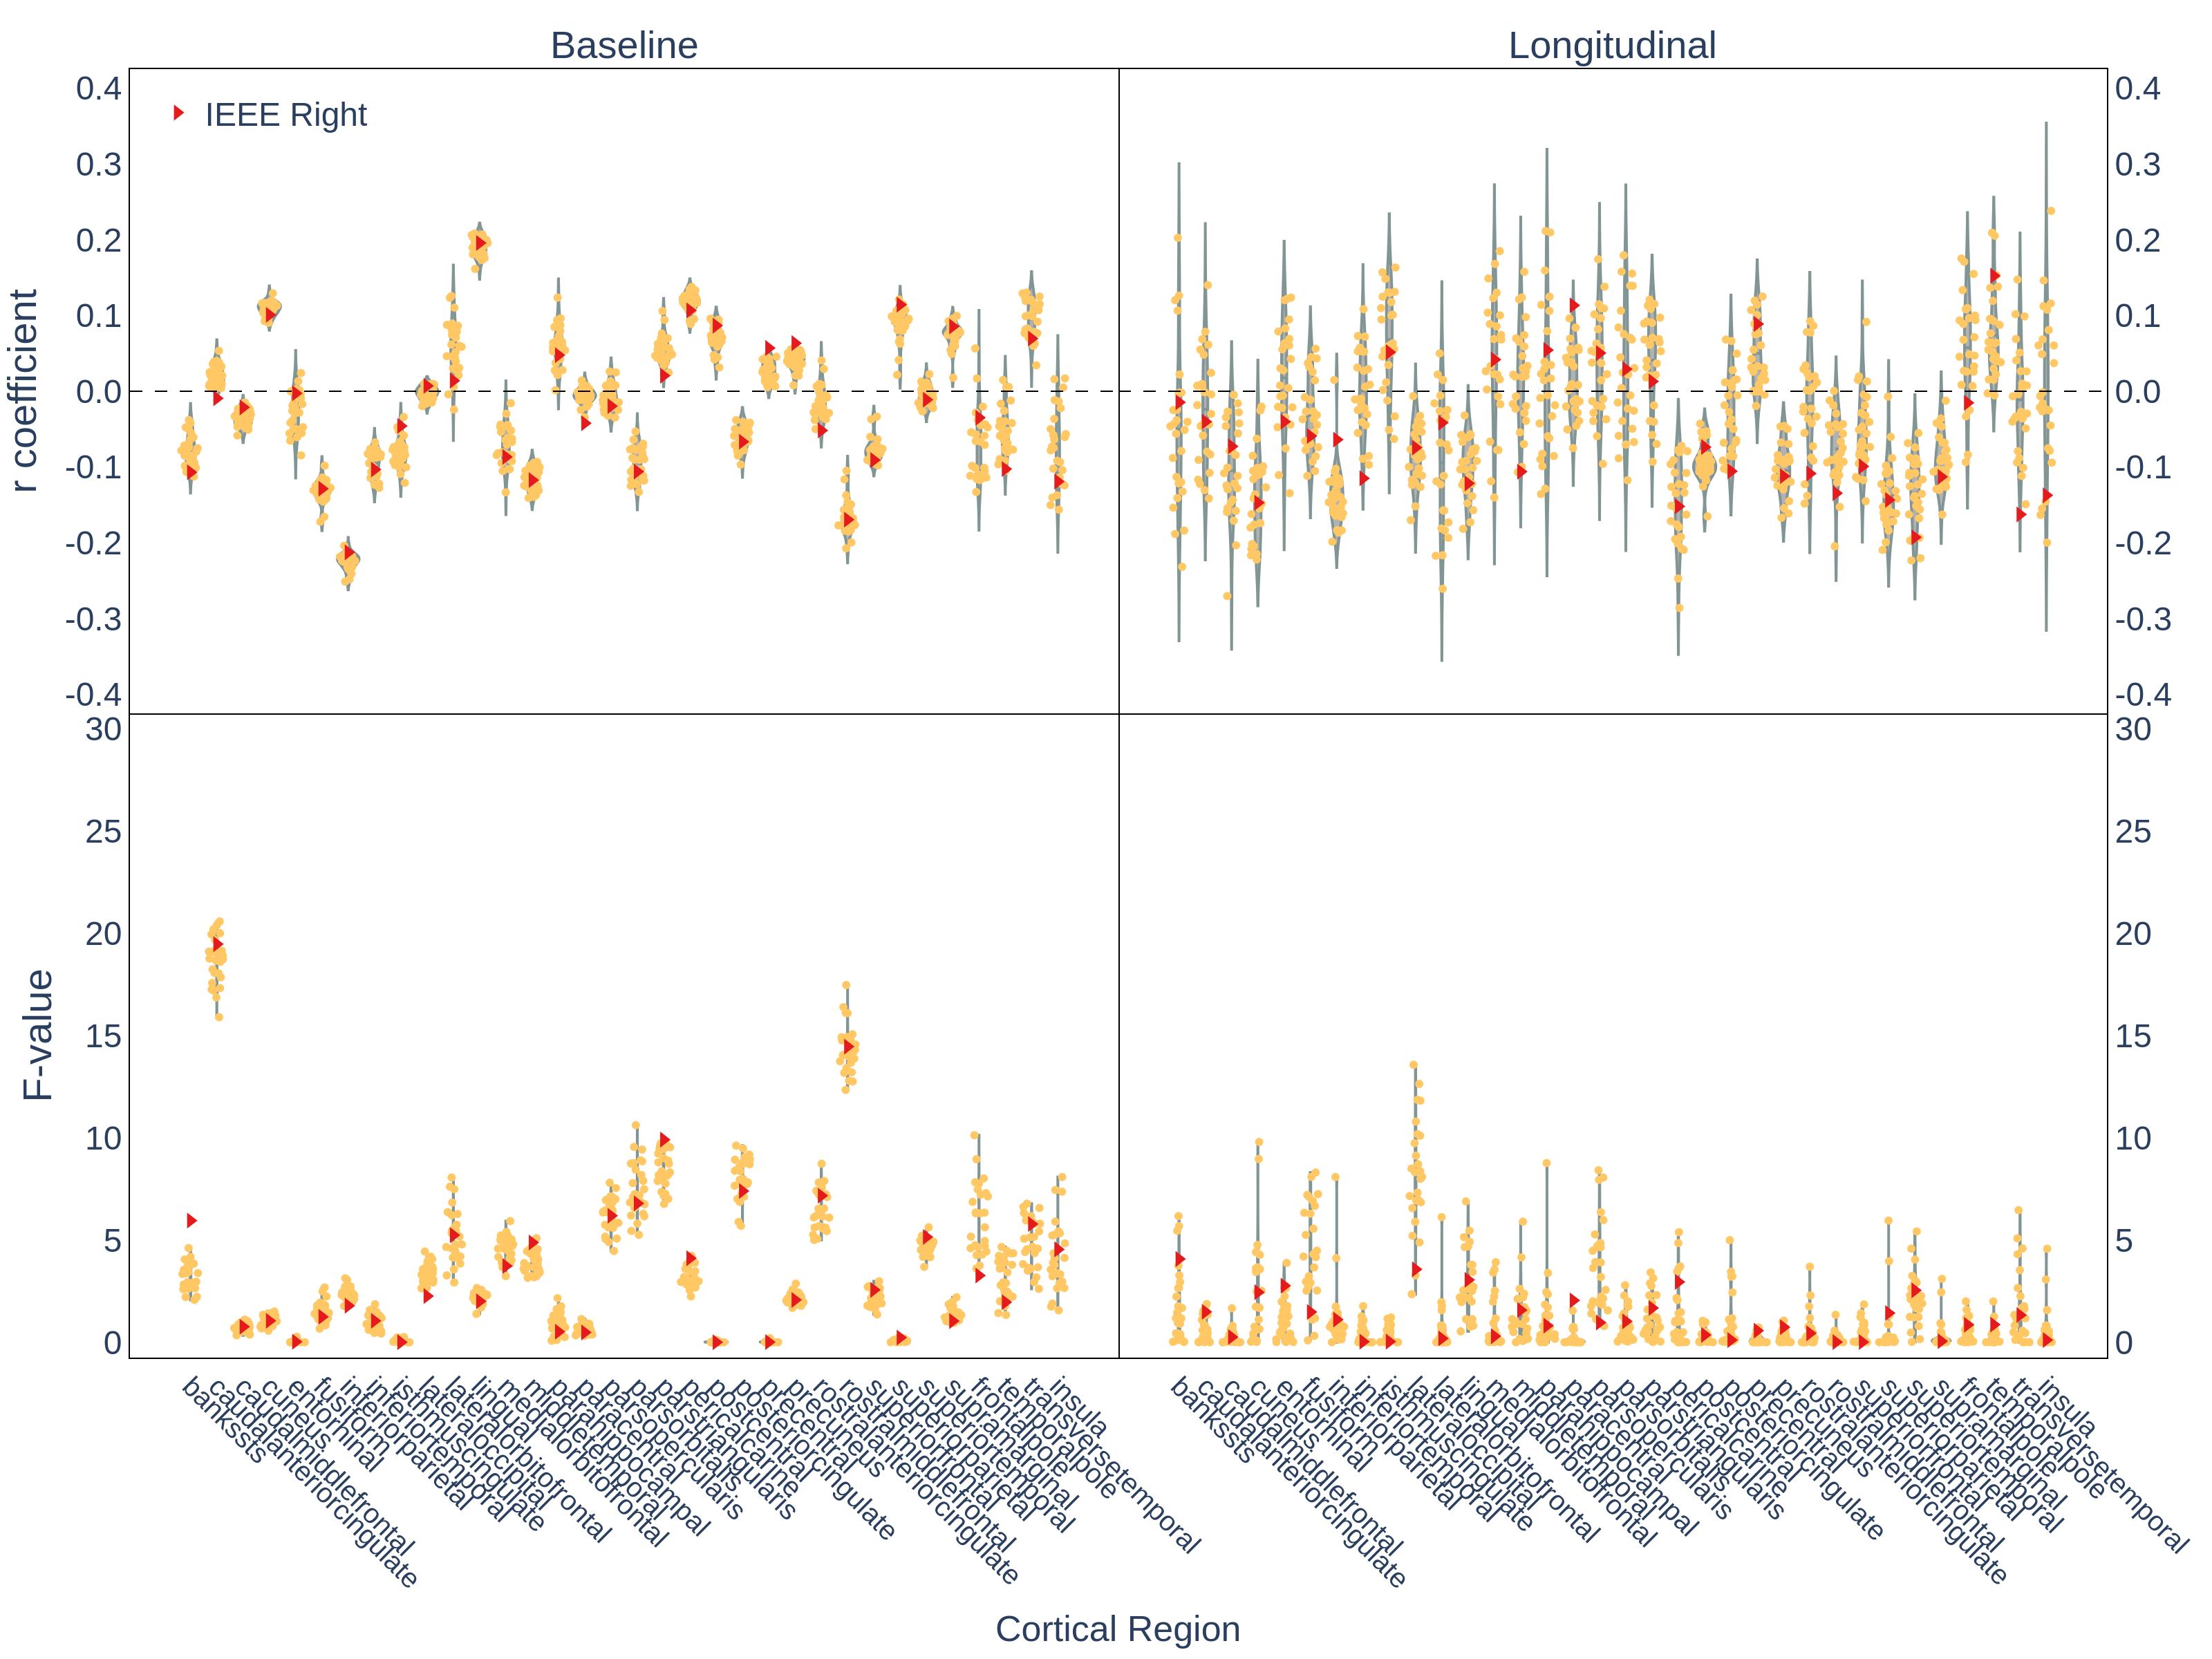

In [ ]:
# Main cortical area coefficient distribution plot
from plotly.subplots import make_subplots

for hemi in ["Left", "Right"]:
    # Create subplots with 2 rows and 2 columns
    fig = make_subplots(
        rows=2,
        cols=2,
        shared_xaxes=True,
        column_titles=["Baseline", "Longitudinal"],
        x_title="Cortical Region",
        vertical_spacing=0.0,
        horizontal_spacing=0.0,
    )

    # Increase font
    fig.update_layout(font=dict(size=18))

    # Add traces to the subplots
    add_pcorr_baseline_cortical_trace(fig, get_preprocessed_data("partial_correlation", "baseline"), hemi=hemi)
    add_pcorr_longitudinal_cortical_trace(fig, get_preprocessed_data("partial_correlation", "longitudinal"), hemi=hemi)
    add_ancova_baseline_cortical_trace(fig, get_preprocessed_data("ancova", "baseline"), hemi=hemi)
    add_ancova_longitudinal_cortical_trace(fig, get_preprocessed_data("ancova", "longitudinal"), hemi=hemi)

    # Set x-axis ticks and labels - remove hemisphere prefix for readability
    simplified_labels = [
        region.replace("lh_", "").replace("rh_", "") for region in cortical_regions
    ]
    fig.update_xaxes(
        title_text="",
        tickvals=list(range(len(cortical_regions))),
        ticktext=simplified_labels,
        tickangle=45,
    )

    yaxis_r_range = [-0.425, 0.425]
    yaxis_r_tickvals = np.arange(-0.5, 0.6, 0.1)
    yaxis_r_tickvals = [
        0 if np.isclose(x, 0) else x for x in yaxis_r_tickvals
    ]  # Replace 0 with 0.0
    yaxis_r_ticktext = [
        "0.0" if np.isclose(x, 0) else str(round(x, 1)) for x in yaxis_r_tickvals
    ]
    yaxis_r_clear = ["" for x in yaxis_r_tickvals]

    yaxis_f_range = [-0.75, 30.75]
    yaxis_f_tickvals = [0, 10]
    yaxis_f_ticktext = ["0", "10"]

    background_color = "White"
    # Update layout for all axes
    fig.update_layout(
        # Primary y-axes (correlation coefficients)
        yaxis1=dict(
            title="r coefficient",
            range=yaxis_r_range,
            dtick=0.1,
            showgrid=False,
            zeroline=False,
            zerolinewidth=2,
            zerolinecolor="DarkSlateGrey",
            tickvals=yaxis_r_tickvals,
            ticktext=yaxis_r_ticktext,
        ),
        yaxis2=dict(
            dtick=0.1,
            showgrid=False,
            range=yaxis_r_range,
            zeroline=False,
            zerolinewidth=2,
            zerolinecolor="DarkSlateGrey",
            tickvals=yaxis_r_tickvals,
            ticktext=yaxis_r_ticktext,
            side="right",
        ),
        yaxis3=dict(
            title="F-value",
            range=yaxis_f_range,
            showgrid=False,
            zeroline=False,
        ),
        yaxis4=dict(showgrid=False, zeroline=False, range=yaxis_f_range, side="right"),
        # Legend settings
        legend=dict(
            x=0.01,
            y=0.99,
            orientation="h",
            yanchor="top",
            xanchor="left",
            bgcolor="rgba(255, 255, 255, 0)",
        ),
        margin=dict(t=50, b=200, r=20),
        plot_bgcolor=background_color,
        paper_bgcolor=background_color,
    )

    fig.add_hline(
        y=0,
        row=1,
        line_color="black",
        line_width=1,
        line_dash="dash",
    )

    # Update each axis individually
    fig.update_layout(
        xaxis1=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
        xaxis2=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
        xaxis3=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
        xaxis4=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
        yaxis1=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
        yaxis2=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
        yaxis3=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
        yaxis4=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
    )

    fig.update_layout(font_family="Helvetica", font_size=24)
    fig.update_annotations(font=dict(family="Helvetica", size=24))

    # Update y position of annotation with "cortical region" text
    for annotation in fig.layout.annotations:
        if annotation.text.lower() == "cortical region":
            annotation.y = -0.16  # Adjust this value as needed for better positioning
            annotation.font.size = 26

    # Update font size for Baseline and Longitudinal titles
    for annotation in fig.layout.annotations:
        if annotation.text in ["Baseline", "Longitudinal"]:
            annotation.font.size = 28  # Set the desired font size for these titles

    fig.update_xaxes(tickfont=dict(family="Helvetica", size=20))

    write_image(
        fig,
        f"cortical_area_coefficients_distribution-{hemi}.pdf",
        width=1600,
        height=1200,
    )
    show_figure(fig, width=1600, height=1200)